# Niwot Stacked Return
* stacked return function
* plots and pie charts 

## Import packages 

In [1]:
# import packages 
%matplotlib widget
# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

# interactive plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

In [2]:
import seaborn as sns # a module that adds some plotting capabilities and makes your plots look better

sns.set() # activates some of the default settings from seaborn
# The following settings just set some defaults for the plots
plt.rcParams['figure.figsize']  = (12,4) #width, height
plt.rcParams['axes.titlesize']  = 14
plt.rcParams['axes.labelsize']  = 12
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
mpl.rcParams['figure.dpi'] = 100

sns.set_style("dark", {"xtick.bottom": True, 'ytick.left': True})

## Load and Clean datasets for use

In [3]:
# AMERIFLUX MET DATA 
niwotflux =   pd.read_csv("/Users/Lumbr/OneDrive - UW/Documents/Washington/UnloadingRegimes/OtherSites/niwot_2017_ameriflux_unload1hr.csv")
niwotflux['datetime']  = pd.DatetimeIndex(niwotflux['datetime'])
# niwotflux.index = pd.DatetimeIndex(niwotflux['datetime'])
# niwotflux.drop(columns=['datetime'], inplace=True)

# OBSERVATIONS CLASSIFICATIONS
niwotobs =  pd.read_csv("/Users/Lumbr/OneDrive - UW/Documents/Washington/UnloadingRegimes/OtherSites/Classifications/datetimeformat_classifications_niwot2017.csv")
niwotobs['datetime'] = pd.to_datetime(niwotobs['datetime'])

# niwotobs.index = pd.DatetimeIndex(niwotobs['datetime'])
# niwotobs.drop(columns=['datetime'], inplace=True)

niwotobs.dropna(axis=0, how='all', inplace=True) #removing row is entire row is NAN #careful with this, without datetime a lot gets removed 

# MERG THEM 
niwotdf = pd.merge(niwotflux, niwotobs, how='outer', on='datetime')
niwotdf.index = pd.DatetimeIndex(niwotdf['datetime'])

In [4]:
# Create symbols for sunlit or not
niwotdf['Esymbol'] = np.nan
# niwotdf['Eminus1symbol'] = np.nan

# open triangle for cloudy, diamond for sunny, open x circle for no radiation data
niwotdf['Esymbol'].mask(niwotdf['E'] == 0., 105, inplace=True) # this is working without fillna
niwotdf['Esymbol'].mask(niwotdf['E'] == 1., 2, inplace=True)  
# niwotdf['Eminus1symbol'].mask(niwotdf['Eminus1symbol'] == 0., 105, inplace=True) # this is working without fillna
# niwotdf['Eminus1symbol'].mask(niwotdf['Eminus1symbol'] == 1., 2, inplace=True)  

# then fillna with 128 for circle with x through it 
niwotdf['Esymbol'] = niwotdf['Esymbol'].fillna(128) 
# niwotdf['Eminus1symbol'] = niwotdf['Eminus1symbol'].fillna(128) 

In [5]:
# Create seperate df for only snow in the canopy timesteps 
df_unload = niwotdf.copy(deep=True)
df_unload = df_unload.dropna(axis=0, how='any', subset=['CD'])

# Have to remove all nans for this plotting to work.... need to come back to this 
df_unload.dropna(inplace=True) #########KEEP THIS IN MIND, COME BACK TO IT

# Create sunlit column
df_unload['Sunlit'] = df_unload.E.copy(deep=True)
df_unload.Sunlit.mask(df_unload.Sunlit == 0, "Not Sunlit", inplace=True)
df_unload.Sunlit.mask(df_unload.Sunlit == 1, "Sunlit Canopy", inplace=True)

# Create unloading classification column
df_unload['Classification'] = df_unload.CD.copy(deep=True)
df_unload.Classification.mask(df_unload.Classification == 0, "Snow Unloading", inplace=True)
df_unload.Classification.mask(df_unload.Classification == 1, "Snow Staying in the Canopy", inplace=True)

snowstaydf   = df_unload.where(df_unload.CD == 1).dropna() # where CD == 1, meaning Snow Staying, make that snowstaydf
snowunloaddf = df_unload.where(df_unload.CD == 0).dropna() # where CD == 0, meaning Snow Unloading, make that snowunloaddf

# Plotting

In [20]:
## Define some plotting constants for easier coding 
plt.close('all')

# Colors
colornosnow = '#D2B48C' # nice tan
colorsnow = '#7dcfd4' # slightly desaturated cyan
colorsnowunload = '#1F15D5' # bright, deep blue 
colorsunny = '#E4E44A' # trying a little less bright 

# Names
namesnow = 'Snow Staying'
namesnowunload = 'Snow Unloading'
group_labels = ['Snow Staying', 'Snow Unloading']

nametemp = "Air Temperature (C)"
namewind = "Wind Speed (m/s)"
nameSW = "Shortwave (W/m2)"

# colors and names 
color1='tomato'; color2='maroon'; color3='navy'
colors = [color1, color2, color3]

# name1 = '600 < SW'; name2 = '400 < SW < 600'; name3 = '400 > SW'
name1 = 'SW > 600'; name2 = '400 < SW < 600'; name3 = 'SW < 400'
label = [name1, name2, name3]

## Make thresholded datasets

In [7]:
# Create copies of the df we want, and then going to classify it by SW threshold
dfSW600 =    df_unload.copy(deep=True) # SW > 600
dfSW400600 = df_unload.copy(deep=True) # SW between 400-600
dfSW400 =    df_unload.copy(deep=True) # SW < 400

# Create for temperature threshold 
dfTg0 =    df_unload.copy(deep=True) # Temp g(greater) 0
dfTl0 =    df_unload.copy(deep=True) # Temp l(less)    0 

# Creating df with only SW > 600
dfSW600.mask(dfSW600.shortwave < 600, inplace=True) # we want where SW > 600, else nan
dfSW600.dropna(inplace=True) # and drop all nan... 
dfSW600stay   = dfSW600.where(dfSW600.CD == 1).dropna()
dfSW600unload = dfSW600.where(dfSW600.CD == 0).dropna()

# Creating df with onyl 400 < SW < 600
dfSW400600.mask(dfSW400600.shortwave > 600, inplace=True) # we want where SW < 600, 
dfSW400600.mask(dfSW400600.shortwave < 400, inplace=True) # and SW > 400, else nan
dfSW400600.dropna(inplace=True) # and drop all nan... 
dfSW400600stay   = dfSW400600.where(dfSW400600.CD == 1).dropna()
dfSW400600unload = dfSW400600.where(dfSW400600.CD == 0).dropna()

# Creating df with SW < 400
dfSW400.mask(dfSW400.shortwave > 400, inplace=True) # we want where SW < 400, else nan
dfSW400.dropna(inplace=True) # and drop all nan...
dfSW400stay   = dfSW400.where(dfSW400.CD == 1).dropna()
dfSW400unload = dfSW400.where(dfSW400.CD == 0).dropna()

# Create df with T > 0 
dfTg0.mask(dfTg0.temp < 0, inplace=True) # we want where T > 0, else nan
dfTg0.dropna(inplace=True) 
dfTg0stay   = dfTg0.where(dfTg0.CD == 1).dropna()
dfTg0unload = dfTg0.where(dfTg0.CD == 0).dropna()

# Create df with T < 0 
dfTl0.mask(dfTl0.temp > 0, inplace=True) # we want where T < 0, else nan 
dfTl0.dropna(inplace=True)
dfTl0stay   = dfTl0.where(dfTl0.CD == 1).dropna()
dfTl0unload = dfTl0.where(dfTl0.CD == 0).dropna()

## stacked return function

In [8]:
def stackedReturn(adata, bdata, x_min, x_max, bin_width):
    
    np.seterr(invalid='ignore') #ignore the runtime errors for 0/0
    
    # define datasets 
    a = adata.copy(deep=True) # snow staying
    b = bdata.copy(deep=True) # snow unloading 

    # note that these give you bin edges, not bin centers
    a_count, a_bin_edges = np.histogram(a, bins=range(int(x_min), int(x_max), int(bin_width)))
    b_count, b_bin_edges = np.histogram(b, bins=range(int(x_min), int(x_max), int(bin_width)))
    
    # to get bin centers, add 1/2 of the bin width (in this case 1/2 of 1 is 0.5) to the bin edges 
    # (but drop the last bin edge value)
    half_range = bin_width / 2
    a_bin_centers = a_bin_edges[:-1] + half_range # SINCE SW IN 100 w/m2 BINS
    b_bin_centers = b_bin_edges[:-1] + half_range

    # calculate percent based on total (a and b) in each bin
    a_percent = a_count / (a_count + b_count)
    b_percent = b_count / (a_count + b_count)

    # convert those int to strings for printing on the plot 
    staycount   = a_count.astype('str')
    unloadcount = b_count.astype('str')

    # remove nans where there was missing a or b data
    a_percent[np.isnan(a_percent)] = 0
    b_percent[np.isnan(b_percent)] = 0

    newarray = np.column_stack((a_bin_centers, a_count, a_percent, b_bin_centers, b_count, b_percent))
    returndf = pd.DataFrame(newarray, columns=['stay_center', 'stay_count', 'stay_percent', 'unload_center', 'unload_count', 'unload_percent' ])
    
    return returndf

# % Of Observation Plots using stackedReturn function

## Create all the required datasets, by running the stackedReturn function

In [9]:
# using the new stackedReturn function to get the df returned with counts for each bin
# temperature
dfSW600_temp1_returndf = stackedReturn(dfSW600stay.temp, dfSW600unload.temp, -25, 15, 1) # temp min, temp max, bin size
dfSW600_temp2_returndf = stackedReturn(dfSW600stay.temp, dfSW600unload.temp, -25, 15, 2) # temp min, temp max, bin size
dfSW600_temp3_returndf = stackedReturn(dfSW600stay.temp, dfSW600unload.temp, -25, 15, 3) # temp min, temp max, bin size
dfSW600_temp4_returndf = stackedReturn(dfSW600stay.temp, dfSW600unload.temp, -25, 15, 4) # temp min, temp max, bin size
dfSW600_temp5_returndf = stackedReturn(dfSW600stay.temp, dfSW600unload.temp, -25, 15, 5) # temp min, temp max, bin size

dfSW460_temp1_returndf = stackedReturn(dfSW400600stay.temp, dfSW400600unload.temp, -25, 15, 1) # temp min, temp max, bin size
dfSW460_temp2_returndf = stackedReturn(dfSW400600stay.temp, dfSW400600unload.temp, -25, 15, 2) # temp min, temp max, bin size
dfSW460_temp3_returndf = stackedReturn(dfSW400600stay.temp, dfSW400600unload.temp, -25, 15, 3) # temp min, temp max, bin size
dfSW460_temp4_returndf = stackedReturn(dfSW400600stay.temp, dfSW400600unload.temp, -25, 15, 4) # temp min, temp max, bin size
dfSW460_temp5_returndf = stackedReturn(dfSW400600stay.temp, dfSW400600unload.temp, -25, 15, 5) # temp min, temp max, bin size

dfSW400_temp1_returndf = stackedReturn(dfSW400stay.temp, dfSW400unload.temp, -25, 15, 1) # temp min, temp max, bin size
dfSW400_temp2_returndf = stackedReturn(dfSW400stay.temp, dfSW400unload.temp, -25, 15, 2) # temp min, temp max, bin size
dfSW400_temp3_returndf = stackedReturn(dfSW400stay.temp, dfSW400unload.temp, -25, 15, 3) # temp min, temp max, bin size
dfSW400_temp4_returndf = stackedReturn(dfSW400stay.temp, dfSW400unload.temp, -25, 15, 4) # temp min, temp max, bin size
dfSW400_temp5_returndf = stackedReturn(dfSW400stay.temp, dfSW400unload.temp, -25, 15, 5) # temp min, temp max, bin size

# wind speed
dfSW600_wind1_returndf = stackedReturn(dfSW600stay.windspeed, dfSW600unload.windspeed, 0, 15, 1) # min, max, bin size
dfSW600_wind2_returndf = stackedReturn(dfSW600stay.windspeed, dfSW600unload.windspeed, 0, 15, 2) # min, max, bin size

dfSW460_wind1_returndf = stackedReturn(dfSW400600stay.windspeed, dfSW400600unload.windspeed, 0, 15, 1) # min, max, bin size
dfSW460_wind2_returndf = stackedReturn(dfSW400600stay.windspeed, dfSW400600unload.windspeed, 0, 15, 2) # min, max, bin size

dfSW400_wind1_returndf = stackedReturn(dfSW400stay.windspeed, dfSW400unload.windspeed, 0, 15, 1) # min, max, bin size
dfSW400_wind2_returndf = stackedReturn(dfSW400stay.windspeed, dfSW400unload.windspeed, 0, 15, 2) # min, max, bin size

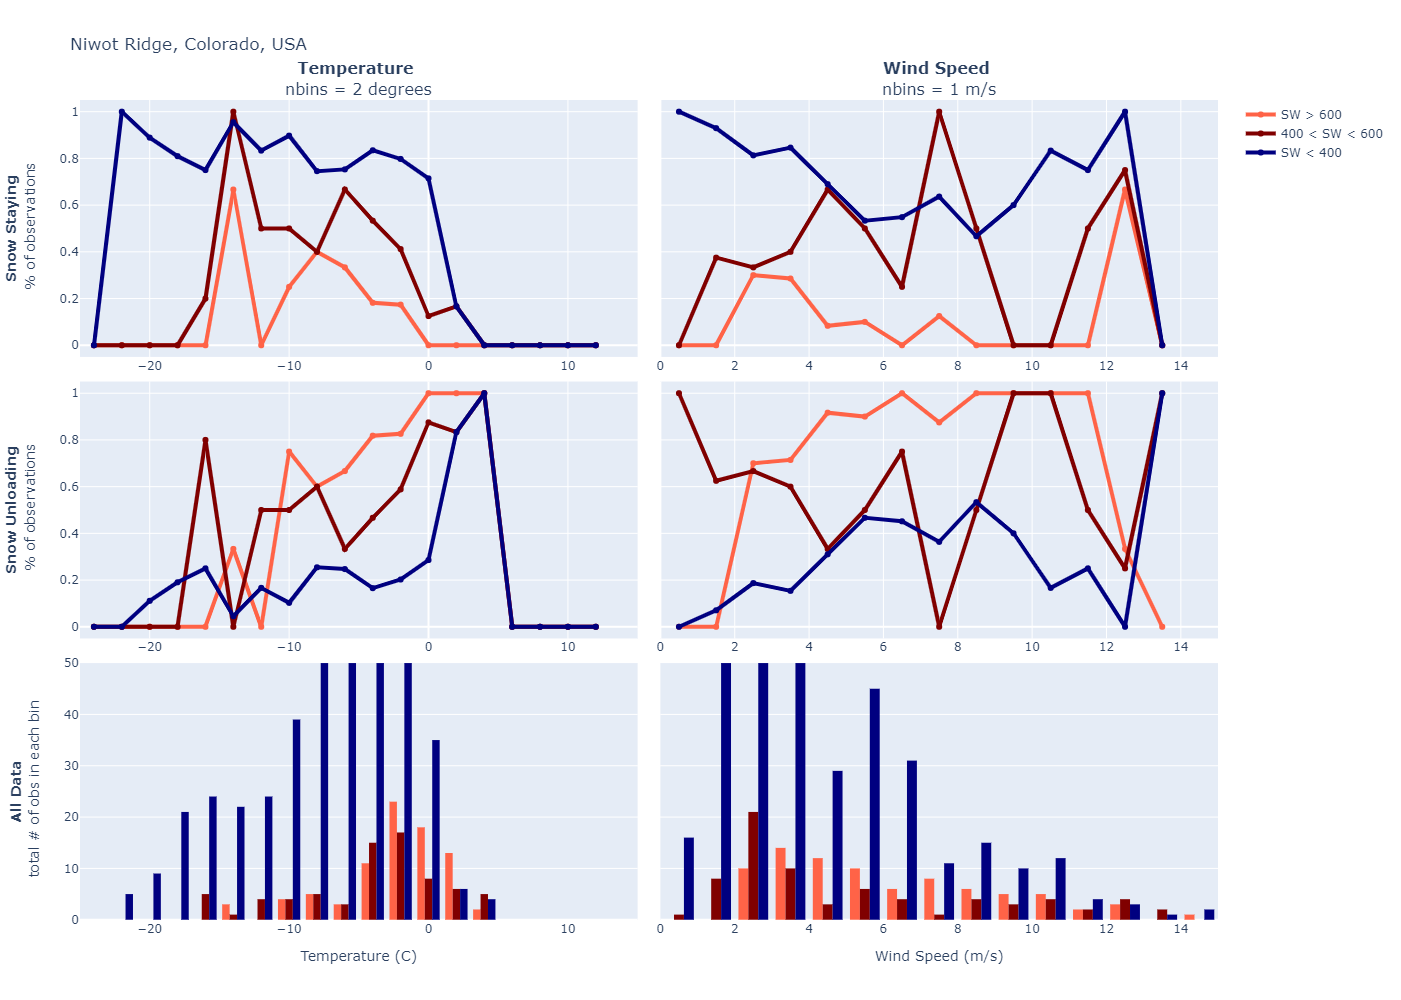

In [21]:
fig = make_subplots(rows=3, cols=2, shared_xaxes=False, shared_yaxes=True, 
                    vertical_spacing=0.03, horizontal_spacing=0.02,
                    subplot_titles=("<b>Temperature </b><br>nbins = 2 degrees", "<b>Wind Speed </b><br>nbins = 1 m/s"))

width = 4

# temp 2 degree bins
fig.add_trace(go.Scatter(x = dfSW600_temp2_returndf['stay_center'], line_color=color1, y = dfSW600_temp2_returndf['stay_percent'], line_width=width, name=name1),row=1, col=1)
fig.add_trace(go.Scatter(x = dfSW460_temp2_returndf['stay_center'], line_color=color2, y = dfSW460_temp2_returndf['stay_percent'], line_width=width, name=name2),row=1, col=1)
fig.add_trace(go.Scatter(x = dfSW400_temp2_returndf['stay_center'], line_color=color3, y = dfSW400_temp2_returndf['stay_percent'], line_width=width, name=name3),row=1, col=1)

fig.add_trace(go.Scatter(x = dfSW600_temp2_returndf['unload_center'], line_color=color1, y = dfSW600_temp2_returndf['unload_percent'], line_width=width, showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x = dfSW460_temp2_returndf['unload_center'], line_color=color2, y = dfSW460_temp2_returndf['unload_percent'], line_width=width, showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x = dfSW400_temp2_returndf['unload_center'], line_color=color3, y = dfSW400_temp2_returndf['unload_percent'], line_width=width, showlegend=False),row=2, col=1)


# wind 1 w/m bins
fig.add_trace(go.Scatter(x = dfSW600_wind1_returndf['stay_center'], line_color=color1, y = dfSW600_wind1_returndf['stay_percent'], line_width=width, showlegend=False),row=1, col=2)
fig.add_trace(go.Scatter(x = dfSW460_wind1_returndf['stay_center'], line_color=color2, y = dfSW460_wind1_returndf['stay_percent'], line_width=width, showlegend=False),row=1, col=2)
fig.add_trace(go.Scatter(x = dfSW400_wind1_returndf['stay_center'], line_color=color3, y = dfSW400_wind1_returndf['stay_percent'], line_width=width, showlegend=False),row=1, col=2)

fig.add_trace(go.Scatter(x = dfSW600_wind1_returndf['unload_center'], line_color=color1, y = dfSW600_wind1_returndf['unload_percent'], line_width=width, showlegend=False),row=2, col=2)
fig.add_trace(go.Scatter(x = dfSW460_wind1_returndf['unload_center'], line_color=color2, y = dfSW460_wind1_returndf['unload_percent'], line_width=width, showlegend=False),row=2, col=2)
fig.add_trace(go.Scatter(x = dfSW400_wind1_returndf['unload_center'], line_color=color3, y = dfSW400_wind1_returndf['unload_percent'], line_width=width, showlegend=False),row=2, col=2)

# row 3
# fig.add_trace(go.Histogram(x = dfSW600.temp, showlegend=False, histfunc='count', marker_color=color1),row=3, col=1)
# fig.add_trace(go.Histogram(x = dfSW400600.temp, showlegend=False, histfunc='count', marker_color=color2),row=3, col=1)
# fig.add_trace(go.Histogram(x = dfSW400.temp, showlegend=False, histfunc='count', marker_color=color3),row=3, col=1)

# fig.add_trace(go.Histogram(x = dfSW600.windspeed,    showlegend=False, histfunc='count', marker_color=color1),row=3, col=2)
# fig.add_trace(go.Histogram(x = dfSW400600.windspeed, showlegend=False, histfunc='count', marker_color=color2),row=3, col=2)
# fig.add_trace(go.Histogram(x = dfSW400.windspeed,    showlegend=False, histfunc='count', marker_color=color3),row=3, col=2)

fig.add_trace(go.Histogram(x = dfSW600.temp, showlegend=False, histfunc='count', marker_color=color1, xbins=dict(start=-25, end=10, size=2), autobinx=False),row=3, col=1)
fig.add_trace(go.Histogram(x = dfSW400600.temp, showlegend=False, histfunc='count', marker_color=color2, xbins=dict(start=-25, end=10, size=2), autobinx=False),row=3, col=1)
fig.add_trace(go.Histogram(x = dfSW400.temp, showlegend=False, histfunc='count', marker_color=color3, xbins=dict(start=-25, end=10, size=2), autobinx=False),row=3, col=1)

fig.add_trace(go.Histogram(x = dfSW600.windspeed,    showlegend=False, histfunc='count', marker_color=color1, xbins=dict(start=0, end=15, size=1), autobinx=False),row=3, col=2)
fig.add_trace(go.Histogram(x = dfSW400600.windspeed, showlegend=False, histfunc='count', marker_color=color2, xbins=dict(start=0, end=15, size=1), autobinx=False),row=3, col=2)
fig.add_trace(go.Histogram(x = dfSW400.windspeed,    showlegend=False, histfunc='count', marker_color=color3, xbins=dict(start=0, end=15, size=1), autobinx=False),row=3, col=2)

# row 3, fix bins
# fig.add_trace(go.Histogram(x = dfSW600.temp,    showlegend=False, histfunc='count', marker_color=color1, bingroup=2, autobinx=False),row=3, col=1)
# fig.add_trace(go.Histogram(x = dfSW400600.temp, showlegend=False, histfunc='count', marker_color=color2, bingroup=2, autobinx=False),row=3, col=1)
# fig.add_trace(go.Histogram(x = dfSW400.temp,    showlegend=False, histfunc='count', marker_color=color3, bingroup=2, autobinx=False),row=3, col=1)

# fig.add_trace(go.Histogram(x = dfSW600.windspeed,    showlegend=False, histfunc='count', marker_color=color1, bingroup=1, autobinx=False), row=3, col=2)
# fig.add_trace(go.Histogram(x = dfSW400600.windspeed, showlegend=False, histfunc='count', marker_color=color2, bingroup=1, autobinx=False), row=3, col=2)
# fig.add_trace(go.Histogram(x = dfSW400.windspeed,    showlegend=False, histfunc='count', marker_color=color3, bingroup=1, autobinx=False), row=3, col=2)

# axes 
fig.update_xaxes(title_text='Temperature (C)',  range=[-25,15],row=3, col=1)
fig.update_xaxes(title_text='',  range=[-25,15],row=1, col=1)
fig.update_xaxes(title_text='',  range=[-25,15],row=2, col=1)


fig.update_xaxes(title_text='Wind Speed (m/s)', range=[0,15],  row=3, col=2)
fig.update_xaxes(title_text='', range=[0,15],  row=1, col=2)
fig.update_xaxes(title_text='', range=[0,15],  row=2, col=2)


fig.update_yaxes(title_text='<b> Snow Staying</b> <br> % of observations', range=[-0.05,1.05], row=1, col=1)
fig.update_yaxes(title_text='<b> Snow Unloading</b> <br> % of observations', range=[-0.05,1.05], row=2, col=1)
fig.update_yaxes(title_text='<b> All Data</b> <br> total # of obs in each bin', range=[-0.05,50], row=3, col=1)


fig.update_layout(height=1000, width=1300, title_text="Niwot Ridge, Colorado, USA")
fig.show()

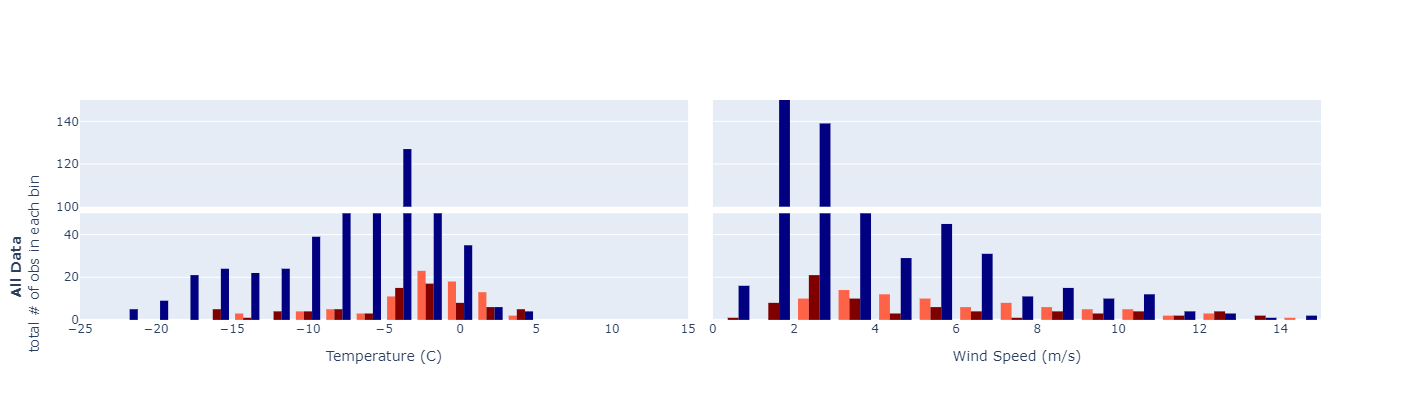

In [22]:
fig = make_subplots(rows=2, cols=2, shared_xaxes=False, shared_yaxes=True, 
                    vertical_spacing=0.03, horizontal_spacing=0.02)

# row 1 
fig.add_trace(go.Histogram(x = dfSW600.temp, showlegend=False, histfunc='count', marker_color=color1, xbins=dict(start=-25, end=10, size=2), autobinx=False),row=1, col=1)
fig.add_trace(go.Histogram(x = dfSW400600.temp, showlegend=False, histfunc='count', marker_color=color2, xbins=dict(start=-25, end=10, size=2), autobinx=False),row=1, col=1)
fig.add_trace(go.Histogram(x = dfSW400.temp, showlegend=False, histfunc='count', marker_color=color3, xbins=dict(start=-25, end=10, size=2), autobinx=False),row=1, col=1)

fig.add_trace(go.Histogram(x = dfSW600.windspeed,    showlegend=False, histfunc='count', marker_color=color1, xbins=dict(start=0, end=15, size=1), autobinx=False),row=1, col=2)
fig.add_trace(go.Histogram(x = dfSW400600.windspeed, showlegend=False, histfunc='count', marker_color=color2, xbins=dict(start=0, end=15, size=1), autobinx=False),row=1, col=2)
fig.add_trace(go.Histogram(x = dfSW400.windspeed,    showlegend=False, histfunc='count', marker_color=color3, xbins=dict(start=0, end=15, size=1), autobinx=False),row=1, col=2)

# row 2 
fig.add_trace(go.Histogram(x = dfSW600.temp, showlegend=False, histfunc='count', marker_color=color1, xbins=dict(start=-25, end=10, size=2), autobinx=False),row=2, col=1)
fig.add_trace(go.Histogram(x = dfSW400600.temp, showlegend=False, histfunc='count', marker_color=color2, xbins=dict(start=-25, end=10, size=2), autobinx=False),row=2, col=1)
fig.add_trace(go.Histogram(x = dfSW400.temp, showlegend=False, histfunc='count', marker_color=color3, xbins=dict(start=-25, end=10, size=2), autobinx=False),row=2, col=1)

fig.add_trace(go.Histogram(x = dfSW600.windspeed,    showlegend=False, histfunc='count', marker_color=color1, xbins=dict(start=0, end=15, size=1), autobinx=False),row=2, col=2)
fig.add_trace(go.Histogram(x = dfSW400600.windspeed, showlegend=False, histfunc='count', marker_color=color2, xbins=dict(start=0, end=15, size=1), autobinx=False),row=2, col=2)
fig.add_trace(go.Histogram(x = dfSW400.windspeed,    showlegend=False, histfunc='count', marker_color=color3, xbins=dict(start=0, end=15, size=1), autobinx=False),row=2, col=2)

# axes 
fig.update_xaxes(visible=False, range=[-25,15], row=1, col=1)
fig.update_xaxes(visible=False, range=[0,15],   row=1, col=2)

fig.update_xaxes(title_text='Temperature (C)',  range=[-25,15],row=2, col=1)
fig.update_xaxes(title_text='Wind Speed (m/s)', range=[0,15],  row=2, col=2)

fig.update_yaxes(title_text='', range=[100,150], row=1, col=1)
fig.update_yaxes(title_text='<b> All Data</b> <br> total # of obs in each bin', range=[-0.05,50], row=2, col=1)


fig.update_layout(height=400, width=1300, title_text="")
fig.show()

## Pie Charts

In [13]:
dfSW600stay_countsum = dfSW600_temp2_returndf.stay_count.sum()
dfSW460stay_countsum = dfSW460_temp2_returndf.stay_count.sum()
dfSW400stay_countsum = dfSW400_temp2_returndf.stay_count.sum()

dfSW600unload_countsum = dfSW600_temp2_returndf.unload_count.sum()
dfSW460unload_countsum = dfSW460_temp2_returndf.unload_count.sum()
dfSW400unload_countsum = dfSW400_temp2_returndf.unload_count.sum()

dfSW600total = dfSW600stay_countsum+dfSW600unload_countsum
dfSW640total = dfSW460stay_countsum+dfSW460unload_countsum
dfSW400total = dfSW400stay_countsum+dfSW400unload_countsum

sumarray = np.column_stack((dfSW600stay_countsum,dfSW460stay_countsum,dfSW400stay_countsum,
                                dfSW600unload_countsum,dfSW460unload_countsum,dfSW400unload_countsum,
                                dfSW600total, dfSW640total, dfSW400total))
sumdf = pd.DataFrame(sumarray, columns=['SW600stay', 'SW460stay','SW400stay','SW600unload','SW460unload','SW400unload', "SW600total", 'SW640total', 'SW400total'])
sumdf.rename(index={0: 'bincount'}, inplace=True)

sumdf_stay   = sumdf.drop(columns=['SW600unload','SW460unload', 'SW400unload', "SW600total", 'SW640total', 'SW400total'])
sumdf_unload = sumdf.drop(columns=['SW600stay','SW460stay', 'SW400stay', "SW600total", 'SW640total', 'SW400total'])
sumdf_total  = sumdf.drop(columns=['SW600stay','SW460stay', 'SW400stay', 'SW600unload','SW460unload', 'SW400unload'])


sumdf = sumdf.T
sumdf['cond'] = sumdf.index.copy(deep=True)

sumdf_stay = sumdf_stay.T
sumdf_stay['cond'] = sumdf_stay.index.copy(deep=True)

sumdf_unload = sumdf_unload.T
sumdf_unload['cond'] = sumdf_unload.index.copy(deep=True)

sumdf_total = sumdf_total.T
sumdf_total['cond'] = sumdf_total.index.copy(deep=True)

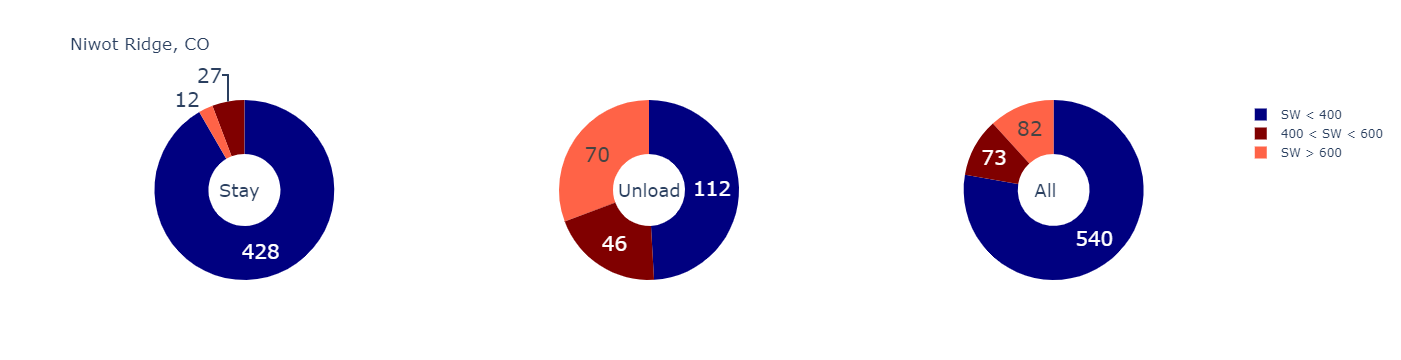

In [23]:
# for pie chat 
values_stay = sumdf_stay.bincount
values_unload = sumdf_unload.bincount
values_all = sumdf_total.bincount

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=label, values=values_stay, name="Stay Pie"),1, 1)
fig.add_trace(go.Pie(labels=label, values=values_unload, name="Unload Pie"),1, 2)
fig.add_trace(go.Pie(labels=label, values=values_all, name="Unload Pie"),1, 3)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, textinfo='value', textfont_size=20, marker=dict(colors=colors))

fig.update_layout(title_text="Niwot Ridge, CO",
    annotations=[dict(text='Stay', x=0.12, y=0.5, font_size=18, showarrow=False),
                 dict(text='Unload', x=0.5,y=0.5, font_size=18, showarrow=False),
                 dict(text=' All', x=0.86,  y=0.5,  font_size=18, showarrow=False)])
fig.show()

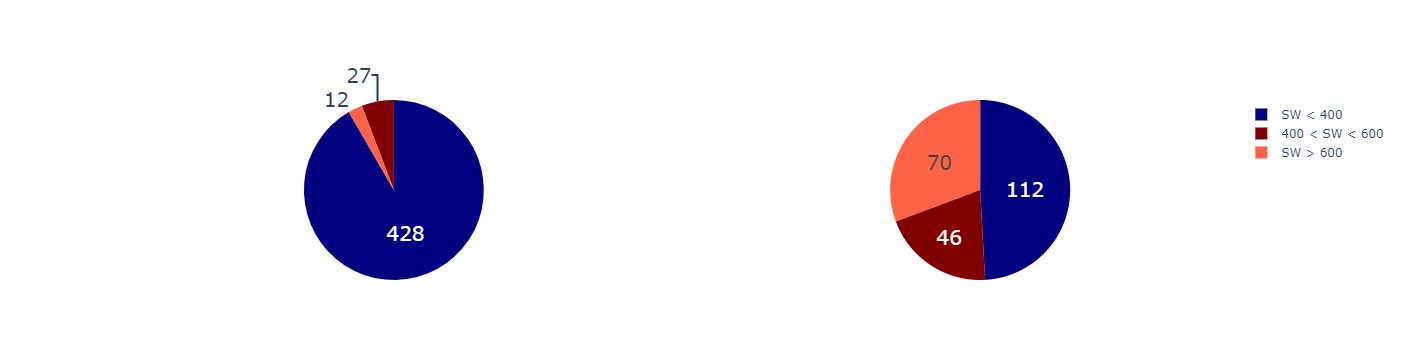

In [15]:
# Create subplots: use 'domain' type for Pie subplot, cannot add with other subplots
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])


fig.add_trace(go.Pie(labels=label, values=values_stay, name="Stay Pie"),1, 1)
fig.add_trace(go.Pie(labels=label, values=values_unload, name="Unload Pie"),1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(textinfo='value', textfont_size=20, marker=dict(colors=colors), row=1, col=1)
fig.update_traces(textinfo='value', textfont_size=20, marker=dict(colors=colors), row=1, col=2)


fig.show()

# Archive Stacked Return Plots

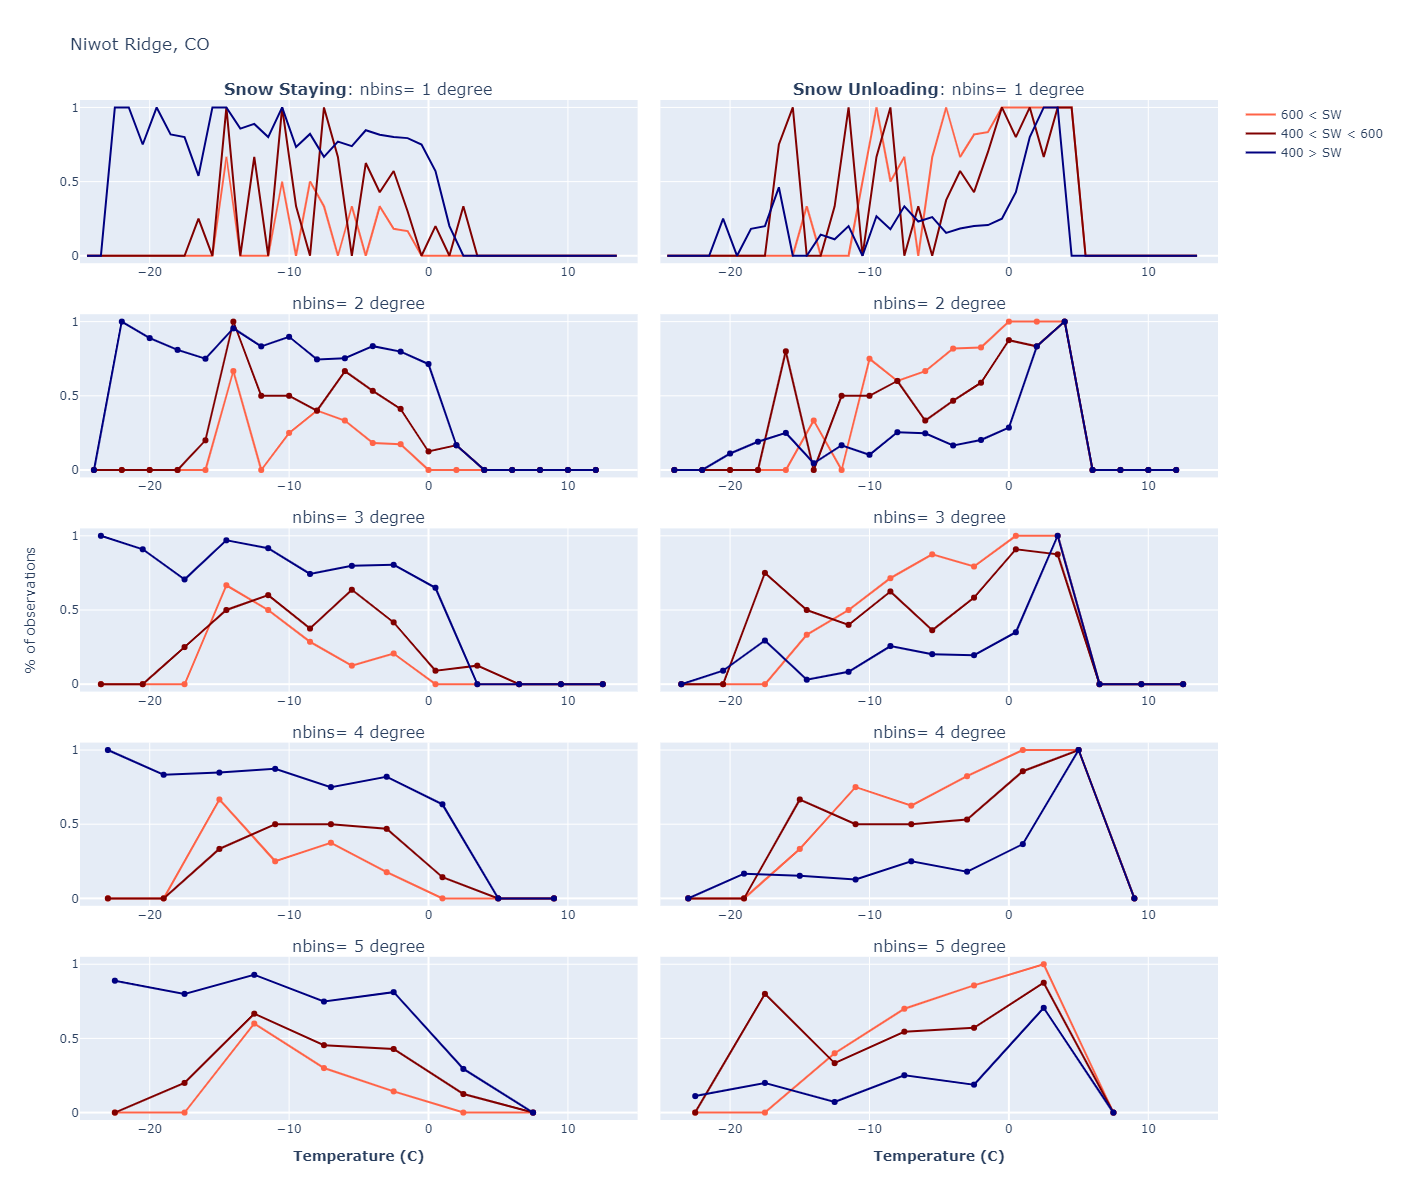

In [16]:
fig = make_subplots(rows=5, cols=2, shared_xaxes=False, shared_yaxes=True, 
                    vertical_spacing=0.05, horizontal_spacing=0.02,
                    subplot_titles=("<b>Snow Staying</b>: nbins= 1 degree", "<b>Snow Unloading</b>: nbins= 1 degree",
                                    'nbins= 2 degree','nbins= 2 degree',
                                    'nbins= 3 degree','nbins= 3 degree',
                                    'nbins= 4 degree','nbins= 4 degree',
                                    'nbins= 5 degree','nbins= 5 degree'))

color1='tomato';color2='maroon';color3='navy'

# temp 1 degree bins
# row 1, column 1: stay
fig.add_trace(go.Scatter(x = dfSW600_temp1_returndf['stay_center'], line_color=color1, y = dfSW600_temp1_returndf['stay_percent'], name='600 < SW'),row=1, col=1)
fig.add_trace(go.Scatter(x = dfSW460_temp1_returndf['stay_center'], line_color=color2, y = dfSW460_temp1_returndf['stay_percent'], name='400 < SW < 600'),row=1, col=1)
fig.add_trace(go.Scatter(x = dfSW400_temp1_returndf['stay_center'], line_color=color3, y = dfSW400_temp1_returndf['stay_percent'], name='400 > SW'),row=1, col=1)

# row 1, column 2: unload
fig.add_trace(go.Scatter(x = dfSW600_temp1_returndf['unload_center'], line_color=color1, y = dfSW600_temp1_returndf['unload_percent'], showlegend=False),row=1, col=2)
fig.add_trace(go.Scatter(x = dfSW460_temp1_returndf['unload_center'], line_color=color2, y = dfSW460_temp1_returndf['unload_percent'], showlegend=False),row=1, col=2)
fig.add_trace(go.Scatter(x = dfSW400_temp1_returndf['unload_center'], line_color=color3, y = dfSW400_temp1_returndf['unload_percent'], showlegend=False),row=1, col=2)

# temp 2 degree bins
# row 2, column 1: stay
fig.add_trace(go.Scatter(x = dfSW600_temp2_returndf['stay_center'], line_color=color1, y = dfSW600_temp2_returndf['stay_percent'], showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x = dfSW460_temp2_returndf['stay_center'], line_color=color2, y = dfSW460_temp2_returndf['stay_percent'], showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x = dfSW400_temp2_returndf['stay_center'], line_color=color3, y = dfSW400_temp2_returndf['stay_percent'], showlegend=False),row=2, col=1)

# row 2, column 2: unload
fig.add_trace(go.Scatter(x = dfSW600_temp2_returndf['unload_center'], line_color=color1, y = dfSW600_temp2_returndf['unload_percent'], showlegend=False),row=2, col=2)
fig.add_trace(go.Scatter(x = dfSW460_temp2_returndf['unload_center'], line_color=color2, y = dfSW460_temp2_returndf['unload_percent'], showlegend=False),row=2, col=2)
fig.add_trace(go.Scatter(x = dfSW400_temp2_returndf['unload_center'], line_color=color3, y = dfSW400_temp2_returndf['unload_percent'], showlegend=False),row=2, col=2)

# temp 3 degree bins
# row 3, column 1: stay
fig.add_trace(go.Scatter(x = dfSW600_temp3_returndf['stay_center'], line_color=color1, y = dfSW600_temp3_returndf['stay_percent'], showlegend=False),row=3, col=1)
fig.add_trace(go.Scatter(x = dfSW460_temp3_returndf['stay_center'], line_color=color2, y = dfSW460_temp3_returndf['stay_percent'], showlegend=False),row=3, col=1)
fig.add_trace(go.Scatter(x = dfSW400_temp3_returndf['stay_center'], line_color=color3, y = dfSW400_temp3_returndf['stay_percent'], showlegend=False),row=3, col=1)

# row 3, column 2: unload
fig.add_trace(go.Scatter(x = dfSW600_temp3_returndf['unload_center'], line_color=color1, y = dfSW600_temp3_returndf['unload_percent'], showlegend=False),row=3, col=2)
fig.add_trace(go.Scatter(x = dfSW460_temp3_returndf['unload_center'], line_color=color2, y = dfSW460_temp3_returndf['unload_percent'], showlegend=False),row=3, col=2)
fig.add_trace(go.Scatter(x = dfSW400_temp3_returndf['unload_center'], line_color=color3, y = dfSW400_temp3_returndf['unload_percent'], showlegend=False),row=3, col=2)

# temp 4 degree bins
# row 4, column 1: stay
fig.add_trace(go.Scatter(x = dfSW600_temp4_returndf['stay_center'], line_color=color1, y = dfSW600_temp4_returndf['stay_percent'], showlegend=False),row=4, col=1)
fig.add_trace(go.Scatter(x = dfSW460_temp4_returndf['stay_center'], line_color=color2, y = dfSW460_temp4_returndf['stay_percent'], showlegend=False),row=4, col=1)
fig.add_trace(go.Scatter(x = dfSW400_temp4_returndf['stay_center'], line_color=color3, y = dfSW400_temp4_returndf['stay_percent'], showlegend=False),row=4, col=1)

# row 4, column 2: unload
fig.add_trace(go.Scatter(x = dfSW600_temp4_returndf['unload_center'], line_color=color1, y = dfSW600_temp4_returndf['unload_percent'], showlegend=False),row=4, col=2)
fig.add_trace(go.Scatter(x = dfSW460_temp4_returndf['unload_center'], line_color=color2, y = dfSW460_temp4_returndf['unload_percent'], showlegend=False),row=4, col=2)
fig.add_trace(go.Scatter(x = dfSW400_temp4_returndf['unload_center'], line_color=color3, y = dfSW400_temp4_returndf['unload_percent'], showlegend=False),row=4, col=2)

# temp 5 degree bins
# row 5, column 1: stay
fig.add_trace(go.Scatter(x = dfSW600_temp5_returndf['stay_center'], line_color=color1, y = dfSW600_temp5_returndf['stay_percent'], showlegend=False),row=5, col=1)
fig.add_trace(go.Scatter(x = dfSW460_temp5_returndf['stay_center'], line_color=color2, y = dfSW460_temp5_returndf['stay_percent'], showlegend=False),row=5, col=1)
fig.add_trace(go.Scatter(x = dfSW400_temp5_returndf['stay_center'], line_color=color3, y = dfSW400_temp5_returndf['stay_percent'], showlegend=False),row=5, col=1)

# row 5, column 2: unload
fig.add_trace(go.Scatter(x = dfSW600_temp5_returndf['unload_center'], line_color=color1, y = dfSW600_temp5_returndf['unload_percent'], showlegend=False),row=5, col=2)
fig.add_trace(go.Scatter(x = dfSW460_temp5_returndf['unload_center'], line_color=color2, y = dfSW460_temp5_returndf['unload_percent'], showlegend=False),row=5, col=2)
fig.add_trace(go.Scatter(x = dfSW400_temp5_returndf['unload_center'], line_color=color3, y = dfSW400_temp5_returndf['unload_percent'], showlegend=False),row=5, col=2)


# axes 
fig.update_xaxes(title_text='',  range=[-25,15],row=1)
fig.update_xaxes(title_text='',  range=[-25,15],row=2)
fig.update_xaxes(title_text='',  range=[-25,15],row=3)
fig.update_xaxes(title_text='',  range=[-25,15],row=4)
fig.update_xaxes(title_text='<b>Temperature (C)</b>',  range=[-25,15],row=5)

# fig.update_xaxes(title_text='Wind Speed (m/s)', range=[0,15],  row=2)

fig.update_yaxes(title_text='', range=[-0.05,1.05], row=1, col=1)
fig.update_yaxes(title_text='% of observations', range=[-0.05,1.05], row=3, col=1)
fig.update_yaxes(title_text='', range=[-0.05,1.05], row=2, col=1)
fig.update_yaxes(title_text='', range=[-0.05,1.05], row=4, col=1)
fig.update_yaxes(title_text='', range=[-0.05,1.05], row=5, col=1)


fig.update_layout(height=1200, width=1200, title_text="Niwot Ridge, CO")
fig.show()

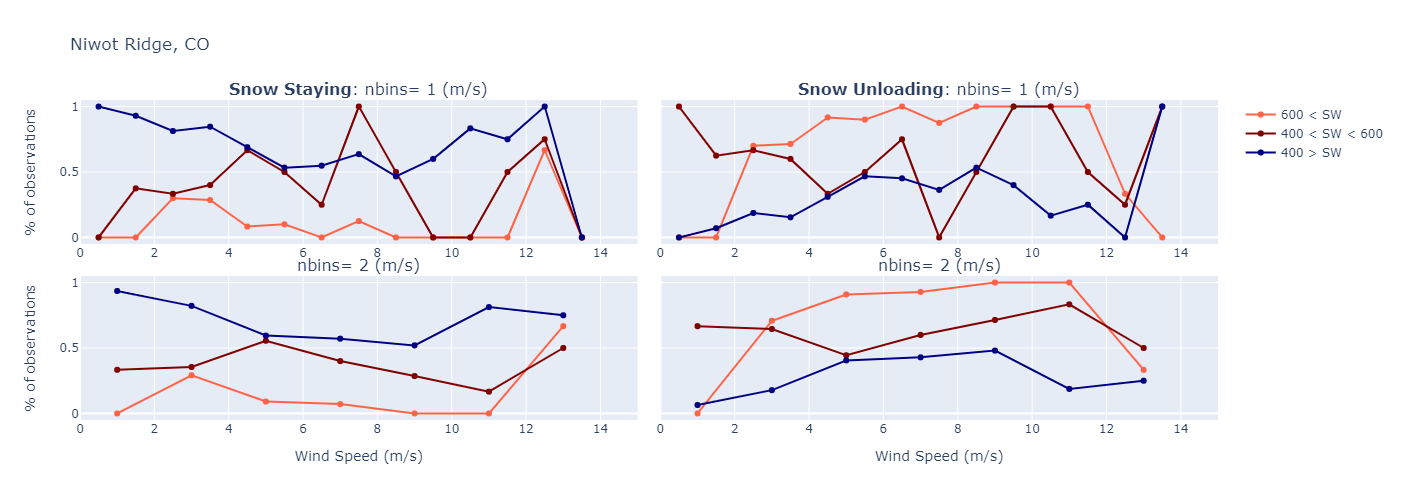

In [17]:
fig = make_subplots(rows=2, cols=2, shared_xaxes=False, shared_yaxes=True, 
                    vertical_spacing=0.1, horizontal_spacing=0.02,
                    subplot_titles=("<b>Snow Staying</b>: nbins= 1 (m/s)", "<b>Snow Unloading</b>: nbins= 1 (m/s)",
                                    'nbins= 2 (m/s)','nbins= 2 (m/s)'))

color1='tomato';color2='maroon';color3='navy'

# wind 1 m/s bins
# row 1, column 1: stay
fig.add_trace(go.Scatter(x = dfSW600_wind1_returndf['stay_center'], line_color=color1, y = dfSW600_wind1_returndf['stay_percent'], name='600 < SW'),row=1, col=1)
fig.add_trace(go.Scatter(x = dfSW460_wind1_returndf['stay_center'], line_color=color2, y = dfSW460_wind1_returndf['stay_percent'], name='400 < SW < 600'),row=1, col=1)
fig.add_trace(go.Scatter(x = dfSW400_wind1_returndf['stay_center'], line_color=color3, y = dfSW400_wind1_returndf['stay_percent'], name='400 > SW'),row=1, col=1)

# row 1, column 2: unload
fig.add_trace(go.Scatter(x = dfSW600_wind1_returndf['unload_center'], line_color=color1, y = dfSW600_wind1_returndf['unload_percent'], showlegend=False),row=1, col=2)
fig.add_trace(go.Scatter(x = dfSW460_wind1_returndf['unload_center'], line_color=color2, y = dfSW460_wind1_returndf['unload_percent'], showlegend=False),row=1, col=2)
fig.add_trace(go.Scatter(x = dfSW400_wind1_returndf['unload_center'], line_color=color3, y = dfSW400_wind1_returndf['unload_percent'], showlegend=False),row=1, col=2)

# wind 2 m/s bins
# row 2, column 1: stay
fig.add_trace(go.Scatter(x = dfSW600_wind2_returndf['stay_center'], line_color=color1, y = dfSW600_wind2_returndf['stay_percent'], showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x = dfSW460_wind2_returndf['stay_center'], line_color=color2, y = dfSW460_wind2_returndf['stay_percent'], showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x = dfSW400_wind2_returndf['stay_center'], line_color=color3, y = dfSW400_wind2_returndf['stay_percent'], showlegend=False),row=2, col=1)

# row 2, column 2: unload
fig.add_trace(go.Scatter(x = dfSW600_wind2_returndf['unload_center'], line_color=color1, y = dfSW600_wind2_returndf['unload_percent'], showlegend=False),row=2, col=2)
fig.add_trace(go.Scatter(x = dfSW460_wind2_returndf['unload_center'], line_color=color2, y = dfSW460_wind2_returndf['unload_percent'], showlegend=False),row=2, col=2)
fig.add_trace(go.Scatter(x = dfSW400_wind2_returndf['unload_center'], line_color=color3, y = dfSW400_wind2_returndf['unload_percent'], showlegend=False),row=2, col=2)

# axes and labels 
fig.update_xaxes(title_text='',  range=[0,15],row=1)
fig.update_xaxes(title_text='Wind Speed (m/s)',  range=[0,15],row=2)

fig.update_yaxes(title_text='% of observations', range=[-0.05,1.05], row=1, col=1)
fig.update_yaxes(title_text='% of observations', range=[-0.05,1.05], row=2, col=1)

fig.update_layout(height=500, width=1000, title_text="Niwot Ridge, CO")
fig.show()

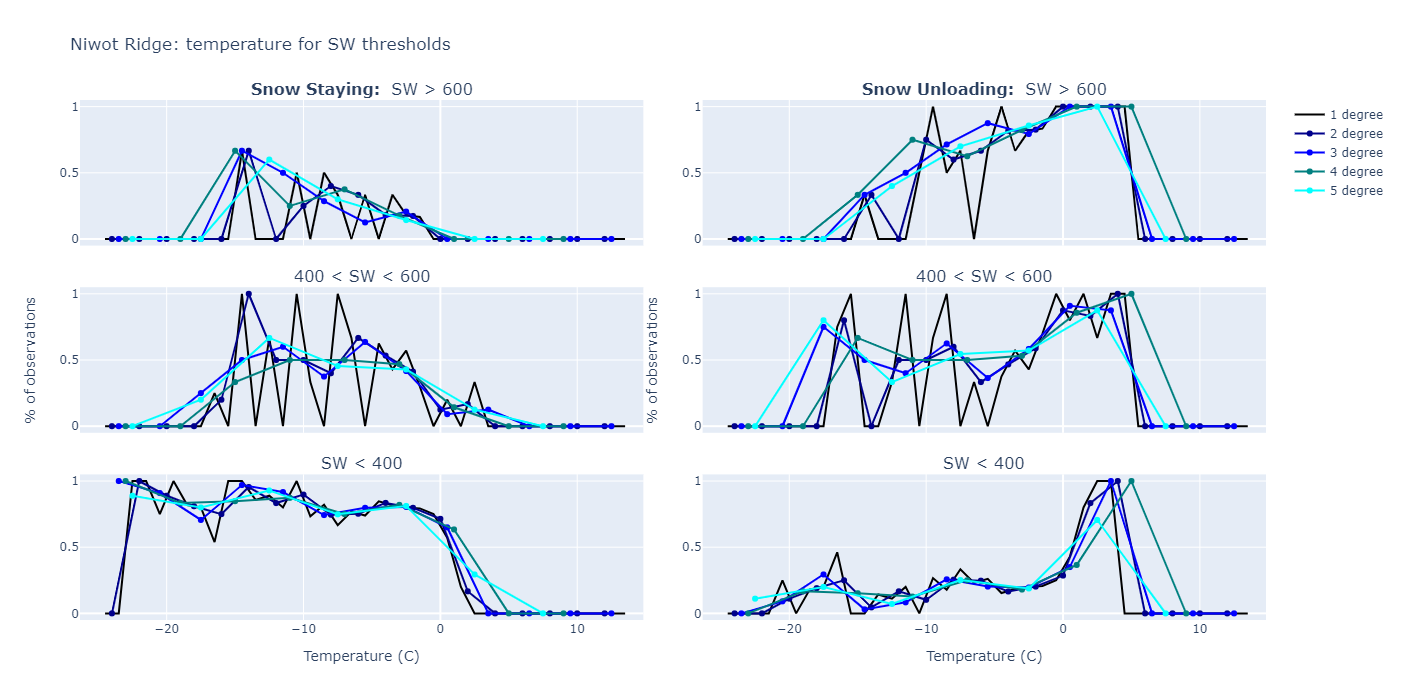

In [18]:
fig = make_subplots(rows=3, cols=2, shared_xaxes=True, vertical_spacing=0.08, horizontal_spacing=0.05,
                   subplot_titles=("<b>Snow Staying: </b> SW > 600", "<b>Snow Unloading: </b> SW > 600",
                                  "400 < SW < 600", "400 < SW < 600",
                                  "SW < 400", "SW < 400"))

color1='black'
color2='darkblue'
color3='blue'
color4='teal'
color5='aqua'

# SW > 600
# row 1, column 1: stay
fig.add_trace(go.Scatter(x = dfSW600_temp1_returndf['stay_center'], line_color=color1, y = dfSW600_temp1_returndf['stay_percent'], name='1 degree'),row=1, col=1)
fig.add_trace(go.Scatter(x = dfSW600_temp2_returndf['stay_center'], line_color=color2, y = dfSW600_temp2_returndf['stay_percent'], name='2 degree'),row=1, col=1)
fig.add_trace(go.Scatter(x = dfSW600_temp3_returndf['stay_center'], line_color=color3, y = dfSW600_temp3_returndf['stay_percent'], name='3 degree'),row=1, col=1)
fig.add_trace(go.Scatter(x = dfSW600_temp4_returndf['stay_center'], line_color=color4, y = dfSW600_temp4_returndf['stay_percent'], name='4 degree'),row=1, col=1)
fig.add_trace(go.Scatter(x = dfSW600_temp5_returndf['stay_center'], line_color=color5, y = dfSW600_temp5_returndf['stay_percent'], name='5 degree'),row=1, col=1)


# row 1, column 2: unload
fig.add_trace(go.Scatter(x = dfSW600_temp1_returndf['unload_center'], line_color=color1, y = dfSW600_temp1_returndf['unload_percent'], showlegend=False),row=1, col=2)
fig.add_trace(go.Scatter(x = dfSW600_temp2_returndf['unload_center'], line_color=color2, y = dfSW600_temp2_returndf['unload_percent'], showlegend=False),row=1, col=2)
fig.add_trace(go.Scatter(x = dfSW600_temp3_returndf['unload_center'], line_color=color3, y = dfSW600_temp3_returndf['unload_percent'], showlegend=False),row=1, col=2)
fig.add_trace(go.Scatter(x = dfSW600_temp4_returndf['unload_center'], line_color=color4, y = dfSW600_temp4_returndf['unload_percent'], showlegend=False),row=1, col=2)
fig.add_trace(go.Scatter(x = dfSW600_temp5_returndf['unload_center'], line_color=color5, y = dfSW600_temp5_returndf['unload_percent'], showlegend=False),row=1, col=2)

# 400 < SW < 600
# row 2, column 1: stay
fig.add_trace(go.Scatter(x = dfSW460_temp1_returndf['stay_center'], line_color=color1, y = dfSW460_temp1_returndf['stay_percent'], showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x = dfSW460_temp2_returndf['stay_center'], line_color=color2, y = dfSW460_temp2_returndf['stay_percent'], showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x = dfSW460_temp3_returndf['stay_center'], line_color=color3, y = dfSW460_temp3_returndf['stay_percent'], showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x = dfSW460_temp4_returndf['stay_center'], line_color=color4, y = dfSW460_temp4_returndf['stay_percent'], showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x = dfSW460_temp5_returndf['stay_center'], line_color=color5, y = dfSW460_temp5_returndf['stay_percent'], showlegend=False),row=2, col=1)

# row 2, column 2: unload
fig.add_trace(go.Scatter(x = dfSW460_temp1_returndf['unload_center'], line_color=color1, y = dfSW460_temp1_returndf['unload_percent'], showlegend=False),row=2, col=2)
fig.add_trace(go.Scatter(x = dfSW460_temp2_returndf['unload_center'], line_color=color2, y = dfSW460_temp2_returndf['unload_percent'], showlegend=False),row=2, col=2)
fig.add_trace(go.Scatter(x = dfSW460_temp3_returndf['unload_center'], line_color=color3, y = dfSW460_temp3_returndf['unload_percent'], showlegend=False),row=2, col=2)
fig.add_trace(go.Scatter(x = dfSW460_temp4_returndf['unload_center'], line_color=color4, y = dfSW460_temp4_returndf['unload_percent'], showlegend=False),row=2, col=2)
fig.add_trace(go.Scatter(x = dfSW460_temp5_returndf['unload_center'], line_color=color5, y = dfSW460_temp5_returndf['unload_percent'], showlegend=False),row=2, col=2)

# 400 > SW
# row 3, column 1: stay
fig.add_trace(go.Scatter(x = dfSW400_temp1_returndf['stay_center'], line_color=color1, y = dfSW400_temp1_returndf['stay_percent'], showlegend=False),row=3, col=1)
fig.add_trace(go.Scatter(x = dfSW400_temp2_returndf['stay_center'], line_color=color2, y = dfSW400_temp2_returndf['stay_percent'], showlegend=False),row=3, col=1)
fig.add_trace(go.Scatter(x = dfSW400_temp3_returndf['stay_center'], line_color=color3, y = dfSW400_temp3_returndf['stay_percent'], showlegend=False),row=3, col=1)
fig.add_trace(go.Scatter(x = dfSW400_temp4_returndf['stay_center'], line_color=color4, y = dfSW400_temp4_returndf['stay_percent'], showlegend=False),row=3, col=1)
fig.add_trace(go.Scatter(x = dfSW400_temp5_returndf['stay_center'], line_color=color5, y = dfSW400_temp5_returndf['stay_percent'], showlegend=False),row=3, col=1)

# row 3, column 2: unload
fig.add_trace(go.Scatter(x = dfSW400_temp1_returndf['unload_center'], line_color=color1, y = dfSW400_temp1_returndf['unload_percent'], showlegend=False),row=3, col=2)
fig.add_trace(go.Scatter(x = dfSW400_temp2_returndf['unload_center'], line_color=color2, y = dfSW400_temp2_returndf['unload_percent'], showlegend=False),row=3, col=2)
fig.add_trace(go.Scatter(x = dfSW400_temp3_returndf['unload_center'], line_color=color3, y = dfSW400_temp3_returndf['unload_percent'], showlegend=False),row=3, col=2)
fig.add_trace(go.Scatter(x = dfSW400_temp4_returndf['unload_center'], line_color=color4, y = dfSW400_temp4_returndf['unload_percent'], showlegend=False),row=3, col=2)
fig.add_trace(go.Scatter(x = dfSW400_temp5_returndf['unload_center'], line_color=color5, y = dfSW400_temp5_returndf['unload_percent'], showlegend=False),row=3, col=2)

# axes 
fig.update_xaxes(title_text='Temperature (C)', row=3)
fig.update_yaxes(title_text='% of observations', range=[-0.05,1.05], row=2)
fig.update_yaxes(title_text='', range=[-0.05,1.05], row=1)
fig.update_yaxes(title_text='', range=[-0.05,1.05], row=3)


fig.update_layout(height=700, width=1000, title_text="Niwot Ridge: temperature for SW thresholds")
fig.show()